In [27]:
from transmon import *
from shapes import *
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.constants import hbar

%matplotlib qt

In [31]:
tr = Transmon(2, 0, Ω=5000, α=-350, t_decay=np.inf, t_dephase=np.inf)
t = np.linspace(0, 1, 1000)

a = destroy(tr.n_levels)
n = a.dag()*a

H0 = tr.Ω*n + 0.5*tr.α*n*(n-1)
H1 = a + a.dag()

def H1_coeffs(t, args):
    
    A,Γ,ω,A_DRAG,φ,offset = args["A"], args["Γ"], args["ω"], args["A_DRAG"], args["φ"], args["offset"]

    return sinusoid(t,1,ω,φ,0) * blackman(t-offset,A,Γ,A_DRAG)

In [32]:
# result = mesolve([H0, [H1, H1_coeffs]], tr.ψ0, t, tr.c_ops, tr.e_ops, args=args)
# [plt.plot(t, i) for i in result.expect]
# plt.show()

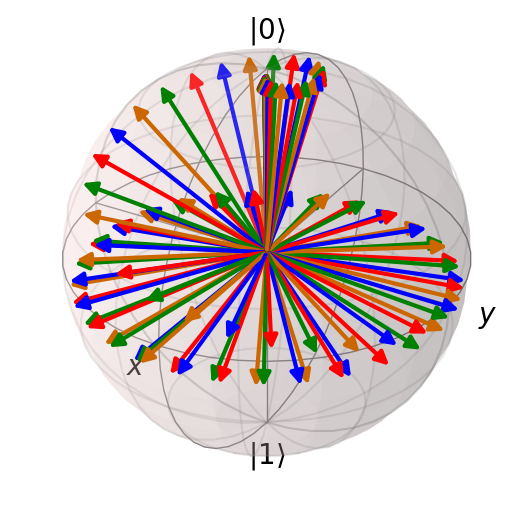

0.9934919560331843


In [35]:
# Xpi2 gate
# 0.25*2*np.pi/5006.177

args_x = {"A": 7.98, "Γ": 0.589888997, "ω": 5006.177, "A_DRAG": -0.011589529, "φ": 0, "offset":0}
args_x = {"A": 7, "Γ": 0.589888997, "ω": 5000, "A_DRAG": -0.011589529, "φ": 0, "offset":0}

initial=tr.ψ0
# initial = (basis(2,0)+basis(2,1)).unit()

result = mesolve([H0, [H1, H1_coeffs]], initial, tlist=t, c_ops=[], e_ops=[], args=args_x)

# t_tmp = np.linspace(0, np.pi/tr.Ω, 10000)
# result = mesolve(H0, initial, tlist=t_tmp, c_ops=[], e_ops=[])

result_compressed = [Qobj(i.full()[:2]) for i in result.states]

b = Bloch()
b.make_sphere()
b.add_states([i for i in result_compressed[::10]])
b.add_states(result_compressed[-1])
b.render()
b.show()
plt.show()

print(fidelity(result_compressed[-1], ((1-1j)*basis(2,0)+(1-1j)*basis(2,1)).unit())**2)

if we want to implement a y90 gate, with $(\theta,\phi,\lambda)=(\pi/2, \pi/2, -\pi/2)$, then we need

1. Z(0)
2. X($\pi/2$)
3. Z($\pi/2$)
4. X($\pi/2$)
5. Z(0)

in a circuit, this is represented on the Bloch sphere as 0 to -y to x

for pulse simulations, we apply a phase of 0 to the bloch sphere

then Xpi/2

then phase of pi/2

then Xpi/2

then phase of 0

so we perform the X gates as normal, and rotate the Bloch sphere in the OPPOSITE direction (ie a Z gate of pi/2 means rotating the Bloch sphere by pi/2 *clockwise)

to calculate the target state, just use a circuit with the original gate U

when implementing a gate U using pulses, decompose it, and then each Z gate adds a phase to the call to the X gate

eg a Zpi/2 gate followed by an Xpi/2 gate is just an Xpi/2 gate with a reverse Ypi/2 gate


In [ ]:
# Ypi2 gate

args_y = {"A": 100, "Γ": 0.8, "ω": 5100, "A_DRAG": 0, "φ": -np.pi/2, "offset":0}

# result = mesolve([H0, [H1, H1_coeffs]], tr.ψ0, tlist=t, c_ops=[], e_ops=[], args=args_y)
result = mesolve([H0, [H1, H1_coeffs]], (basis(3,0)-1j*basis(3,1)).unit(), tlist=t, c_ops=[], e_ops=[], args=args_y)
result_y = Qobj(result.states[-1].full()[:2])

b = Bloch()
b.make_sphere()
b.add_states(Qobj((basis(3,0)-1j*basis(3,1)).unit().full()[:2]))
b.add_states(result_y)
b.render()
b.show()
plt.show()

In [ ]:
# implement Y90 using X90 + phase shift
# Y90 is done using Z0, Xpi2, Zpi2, Xpi2, Z0

# Xpi2 gate

args_x = {"A": 7.98, "Γ": 0.589888997, "ω": 5006.177, "A_DRAG": -0.011589529, "φ": 0, "offset":0}

# Z0
args_x["φ"] += 0

# Xpi2
result1 = mesolve([H0, [H1, H1_coeffs]], tr.ψ0, tlist=t, c_ops=[], e_ops=[], args=args_x)

# Zpi2
args_x["φ"] += np.pi/2

# Xpi2
result2 = mesolve([H0, [H1, H1_coeffs]], result1.states[-1], tlist=t, c_ops=[], e_ops=[], args=args_x)

# Z0
args_x["φ"] += 0

results_compressed = [Qobj(i.full()[:2]) for i in result1.states]
b = Bloch()
b.make_sphere()
b.add_states([i for i in results_compressed[-1]])
b.render()
b.show()
plt.show()

In [ ]:
initial = result_y
initial_extended=Qobj(np.append(initial.full(), 0))

subsequent = mesolve([H0, [H1, H1_coeffs]], initial_extended, tlist=t, c_ops=[], e_ops=[], args=args_y)

subsequent = Qobj(result.states[-1].full()[:2])

b = Bloch()
b.make_sphere()
b.add_states(initial)
b.add_states(subsequent)
b.render()
b.show()
plt.show()